In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import random
import cv2
import matplotlib.pyplot as plt

import copy
from scipy import ndimage

# Loading images

In [2]:
PATH = Path('./data/v2/')

In [3]:
def load_img(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [4]:
content = load_img(PATH/'dancing.jpg')
style = load_img(PATH/'picasso.jpg')

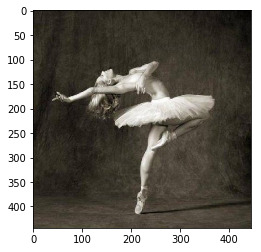

In [5]:
plt.imshow(content)

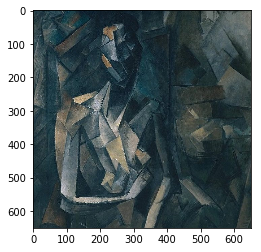

In [6]:
plt.imshow(style)

# Preprocessing

In [7]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

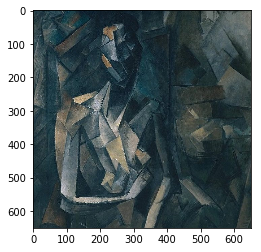

In [8]:
plt.imshow(center_crop(style))

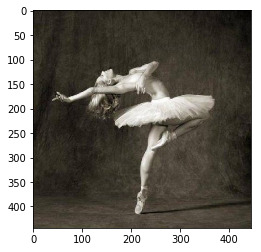

In [9]:
plt.imshow(center_crop(content))

In [10]:
content_resize = cv2.resize(center_crop(content), (500, 500))
style_resize = cv2.resize(center_crop(style), (500, 500))

In [11]:
def transform_images(img):
    img = np.rollaxis(img, 2)
    img = img[None]
    return torch.tensor(img, dtype=torch.float32)

In [12]:
content_trf = transform_images(content_resize)
style_trf = transform_images(style_resize)

# Model

In [13]:
cnn = models.vgg19(pretrained=True).eval()

In [14]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [15]:
normalization = Normalization(cnn_normalization_mean, cnn_normalization_std)
model = nn.Sequential(normalization)

/Users/liyingli/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/Users/liyingli/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


## content&style optimization

In [16]:
content_layers = ['20']
style_layers = ['1', '6', '11', '20', '29']

In [17]:
layers = list(cnn.children())[0][:20]

content_cnn = nn.Sequential(normalization)
for i, l in enumerate(layers):
    content_cnn.add_module('{}'.format(i+1), l)

In [18]:
class StyleCnn(nn.Module):
    def __init__(self):
        super(StyleCnn, self).__init__()
        self.select = ['1', '6', '11', '20', '29']
        self.cnn = models.vgg19(True).features
        for param in self.cnn.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = []
        for name, layer in self.cnn._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [19]:
style_cnn_initial = StyleCnn()
style_cnn = nn.Sequential(normalization)
for i, l in enumerate(list(style_cnn_initial.children())[0]):
    style_cnn.add_module('{}'.format(i+1), l)

In [20]:
def gram_matrix(input):
    a, b, c, d = input.size()  
    features = input.view(a * b, c * d)  
    G = torch.mm(features, features.t())  
    return G.div(a * b * c * d)

In [21]:
# class ContentLoss(nn.Module):
#     def __init__(self, target):
#         super(ContentLoss, self).__init__()
#         self.target = target.detach()

#     def forward(self, input):
#         self.loss = F.mse_loss(input, self.target)
#         return input


# class StyleLoss(nn.Module):
#     def __init__(self, target_feature):
#         super(StyleLoss, self ).__init__()
#         self.target = gram_matrix(target_feature).detach()
#     def forward(self, input):
#         G = gram_matrix(input)
#         self.loss = F.mse_loss(G, self.target)
#         return input

### training content

In [22]:
input_img = torch.randn(content_trf.data.size())

In [23]:
def get_input(lr=0.01):
    opt_img = np.random.uniform(0, 1, size=content_resize.shape).astype(np.float32)
    opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
    im_opt = transform_images(opt_img)
    im_opt.requires_grad=True
    optimizer = optim.Adam([im_opt], lr=0.01)
    return im_opt, optimizer

def train_image(optimizer, targ_v, im_opt, iters):
    for i in range(iters):
        optimizer.zero_grad()
        loss = F.mse_loss(content_cnn(im_opt), targ_v.detach())
        loss.backward()
        optimizer.step()
        im_opt.data.clamp_(0, 1)
        if i%200 == 1:
            print(loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [24]:
targ_v = content_cnn(content_trf)

In [25]:
im_opt, optimizer = get_input(lr=0.01)

In [26]:
im_opt = train_image(optimizer, targ_v, im_opt, 2000)

1273304.5


KeyboardInterrupt: 

### training style

In [ ]:
def get_input(lr=0.01):
    opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
    opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
    im_opt = transform_images(opt_img)
    im_opt.requires_grad=True
    optimizer = optim.Adam([im_opt], lr=0.01)
    return im_opt, optimizer

In [ ]:
opt_img, optimizer = get_input(lr=0.01)
style_cnn = style_cnn.eval()

In [ ]:
im_style_f = style_cnn(style_trf)

In [ ]:
targ_g = [gram_matrix(f).detach() for f in im_style_f]

In [ ]:
def train_style(optimizer, targ_g, im_opt, iters):
    for i in range(iters):
        optimizer.zero_grad()
            # run the model
        out = vgg(im_opt)
        input_g = [gram_matrix(f) for f in out]
        losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
        loss = sum(losses)
        loss.backward()     
        optimizer.step()
        im_opt.data.clamp_(0, 1)
        if i%200 == 1:
            print(loss.item())
    return im_opt

In [ ]:
im_opt, optimizer = get_input(lr=0.1)

In [ ]:
im_opt = train_style(optimizer, targ_g, im_opt, 2000)